In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify
from sqlalchemy import text
from pprint import pprint

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables
metadata = sqlalchemy.MetaData()
metadata.reflect(bind=engine)

Base = automap_base(metadata=metadata)
Base.prepare()

In [6]:
# View all of the classes that automap found
class_names = Base.classes.keys()
print("Classes found by automap:", class_names)

Classes found by automap: ['measurement', 'station']


In [7]:

# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB

Session = sessionmaker(bind=engine)
session = Session()


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()

print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


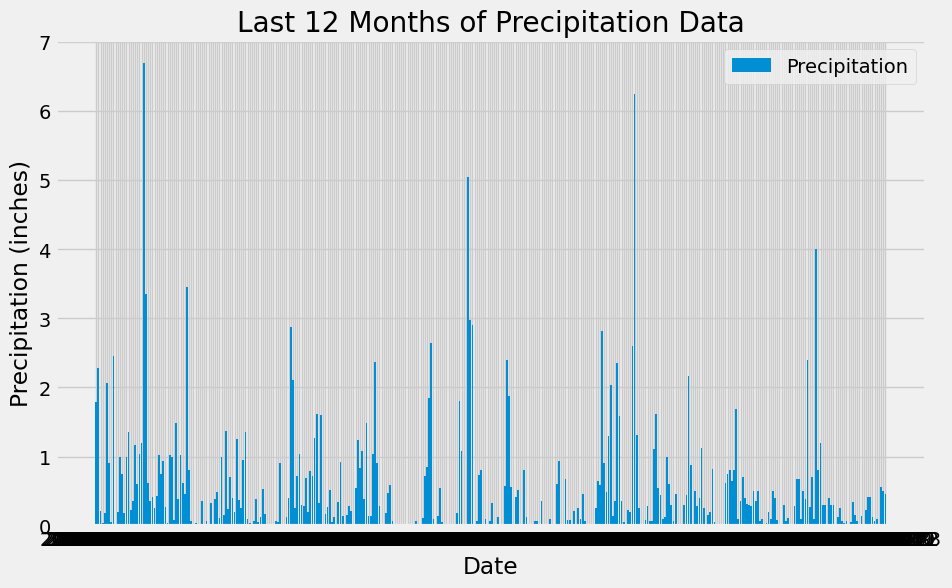

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()

# Convert most_recent_date to a datetime object
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate one year ago from the most recent date
one_year_ago = most_recent_date - pd.DateOffset(years=1)

one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(measurement.date, measurement.prcp)\
                  .filter(text(f"{measurement.date} >= :one_year_ago"))\
                  .params(one_year_ago=one_year_ago_str)\
                  .order_by(measurement.date)\
                  .all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['date'], df['precipitation'], label='Precipitation')
plt.title('Last 12 Months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.legend()
plt.tight_layout
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Calculate summary statistics for the precipitation column
summary_stats = df['precipitation'].describe()

summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))\
                         .group_by(measurement.station)\
                         .order_by(func.count(measurement.station).desc())\
                         .all()

# Print the results
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id = 'USC00519281'

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs))\
                           .filter(measurement.station == active_station_id)\
                           .all()
                           
print(f"Temperature Statistics for Station {active_station_id}:")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


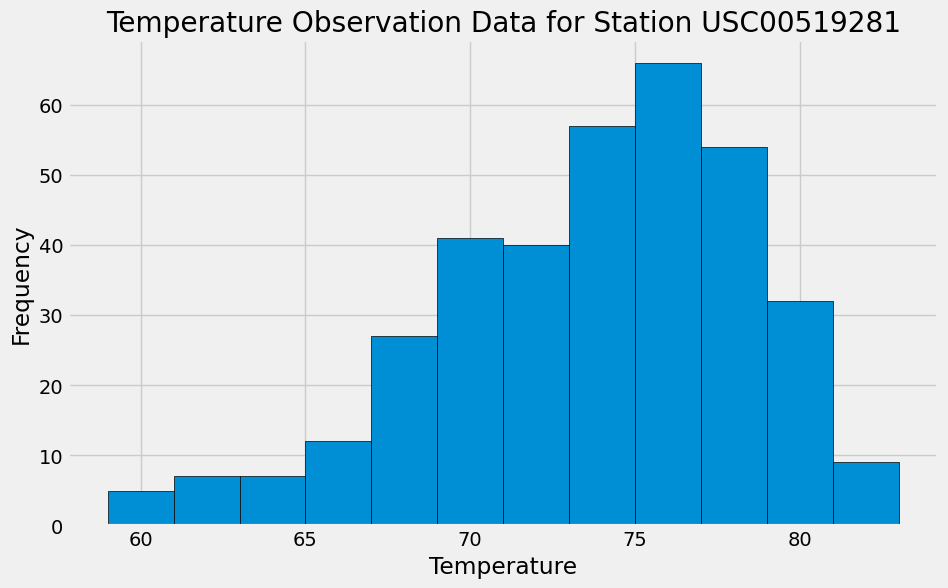

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

specific_station_id = 'USC00519281'

# Calculate the date one year from the most recent date in the data set
most_recent_date = session.query(func.max(measurement.date))\
                          .filter(measurement.station == specific_station_id)\
                          .scalar()

# Convert most_recent_date to a datetime object
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate one year ago from the most recent date
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Convert one_year_ago to a string
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the last 12 months of temperature observation data for the specified station
results = session.query(measurement.date, measurement.tobs)\
                  .filter(measurement.station == specific_station_id)\
                  .filter(measurement.date >= one_year_ago_str)\
                  .order_by(measurement.date)\
                  .all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(results, columns=['date', 'temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observation Data for Station {specific_station_id}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [21]:
# Close Session
session.close()